In [1]:
!nvidia-smi

Fri Apr  3 22:33:32 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     7W /  75W |     91MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [12]:
%load_ext tensorboard
%tensorboard --logdir='./log' --port=6006

Reusing TensorBoard on port 6006 (pid 2964), started 0:20:22 ago. (Use '!kill 2964' to kill it.)

In [13]:
!apt-get update
!apt-get install -y libsm6 libxext6 libxrender-dev

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease                  
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Reading package lists... Done                    
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libsm6 is already the newest version (2:1.2.2-1).
libxext6 is already the newest version (2:1.3.3-1).
libxrender-dev is already the newest version (1:0.9.10-1).
0 upgraded, 0 newly installed, 0 to

In [14]:
!pip install --upgrade pip

Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (20.0.2)


In [15]:
!pip install pandas stable_baselines opencv-python

In [77]:
import os
import pickle
import pandas as pd
from datetime import datetime
from stable_baselines.common.policies import MlpLstmPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import PPO2
from rlenv.StockTradingEnv0 import StockTradingEnv

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

font = fm.FontProperties(fname='font/wqy-microhei.ttc')
# plt.rc('font', family='Source Han Sans CN')
plt.rcParams['axes.unicode_minus'] = False


def stock_trade(stock_file):
    day_profits = []
    action_log=[]
    df = pd.read_csv(stock_file)
    df = df.sort_values('date')
    df_train,df_test,_=np.split(df, [int(.6*len(df)),int(len(df))-1])
    df_test=df_test.reset_index(drop = True) 
    timesteps=int(2e2)
    
    # The algorithms require a vectorized environment to run
    env = DummyVecEnv([lambda: StockTradingEnv(df_train)])

    model = PPO2(MlpLstmPolicy, env, nminibatches=1,verbose=0, tensorboard_log='./log')
    model.learn(total_timesteps=timesteps)
    model.save('./model/ppo2-'+datetime.now().strftime("%m%d%Y-%H%M-")+str(timesteps))

    env = DummyVecEnv([lambda: StockTradingEnv(df_test)])
    obs = env.reset()
    for i in range(len(df_test) - 1):
        action, _states = model.predict(obs)
        action_log.append(action[0][0])
        print(action)
        obs, rewards, done, info = env.step(action)
        profit = env.render(mode='human')
        day_profits.append(profit)
        if done:
            break
    return day_profits,action_log


def find_file(path, name):
    # print(path, name)
    for root, dirs, files in os.walk(path):
        for fname in files:
            if name in fname:
                return os.path.join(root, fname)


def test_a_stock_trade(stock_code):
    stock_file = find_file('./stockdata/train', str(stock_code))

    daily_profits,action_log = stock_trade(stock_file)
    return daily_profits,action_log,stock_code

def plot_results(daily_profits,action_log,stock_code):
    fig, ax = plt.subplots()
    ax.plot(daily_profits, '-o', label=stock_code, ms=10, alpha=0.7, mfc='orange')
    ax.grid()
    plt.xlabel('step')
    plt.ylabel('profit')
    ax.legend(prop=font)
    plt.savefig(f'./img/{stock_code}.png')
    fig1, ax1 = plt.subplots()
    ax1.plot(action_log, '-r', label=stock_code, marker='o', ms=10, alpha=0.7, mfc='orange')
    ax1.grid()
    plt.xlabel('step')
    plt.ylabel('profit')
    ax1.legend(prop=font)
    # plt.show()
    


def multi_stock_trade():
    start_code = 600000
    max_num = 3000

    group_result = []

    for code in range(start_code, start_code + max_num):
        stock_file = find_file('./stockdata/train', str(code))
        if stock_file:
            try:
                profits = stock_trade(stock_file)
                group_result.append(profits)
            except Exception as err:
                print(err)

    with open(f'code-{start_code}-{start_code + max_num}.pkl', 'wb') as f:
        pickle.dump(group_result, f)


In [78]:
if __name__ == '__main__':
    # multi_stock_trade()
    daily_profits,action_log,stock_code=test_a_stock_trade('sh.600036')
    
    # ret = find_file('./stockdata/train', '600036')
    # print(ret)

/tf/notebooks/rlenv/StockTradingEnv0.py:80: RuntimeWarning: invalid value encountered in double_scalars
  prev_cost + additional_cost) / (self.shares_held + shares_bought)
/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[0.8514546  0.20877747]]
------------------------------
Step: 1
Balance: 237382.72598802982
Shares held: 3663 (Total sold: 0)
Avg cost for held shares: 17.094532899800758 (Total sales value: 0)
Net worth: 300000.0 (Max net worth: 300000)
Profit: 0.0
[[0.400199  0.8707242]]
------------------------------
Step: 2
Balance: 30699.853035976674
Shares held: 15602 (Total sold: 0)
Avg cost for held shares: 17.2606170339715 (Total sales value: 0)
Net worth: 300795.0187783281 (Max net worth: 300795.0187783281)
Profit: 795.0187783280853
[[0.         0.45887193]]
------------------------------
Step: 3
Balance: 16630.82427134287
Shares held: 16401 (Total sold: 0)
Avg cost for held shares: 17.27755476670064 (Total sales value: 0)
Net worth: 305424.4923173492 (Max net worth: 305424.4923173492)
Profit: 5424.492317349184
[[0. 1.]]
------------------------------
Step: 4
Balance: 0.6493880839334452
Shares held: 17314 (Total sold: 0)
Avg cost for held shares: 17.326981091135274 (Total sales value: 0)
Net

[[0. 0.]]
------------------------------
Step: 75
Balance: 8.968415265428689
Shares held: 18029 (Total sold: 67196)
Avg cost for held shares: 16.23118792436502 (Total sales value: 1049251.1892120766)
Net worth: 289442.807577215 (Max net worth: 315971.9829345463)
Profit: -10557.192422784981
[[1.1967704  0.85900676]]
------------------------------
Step: 76
Balance: 251901.86429188453
Shares held: 2542 (Total sold: 82683)
Avg cost for held shares: 16.23118792436502 (Total sales value: 1301144.0850886956)
Net worth: 293246.975760753 (Max net worth: 315971.9829345463)
Profit: -6753.0242392470245
[[0.        0.7091529]]
------------------------------
Step: 77
Balance: 73273.14731514544
Shares held: 13459 (Total sold: 82683)
Avg cost for held shares: 16.33764742406382 (Total sales value: 1301144.0850886956)
Net worth: 293495.17734078725 (Max net worth: 315971.9829345463)
Profit: -6504.822659212747
[[0.703007   0.05422673]]
------------------------------
Step: 78
Balance: 69305.68247196643
Sha

[[0. 0.]]
------------------------------
Step: 149
Balance: 9.304822016012622
Shares held: 18027 (Total sold: 113695)
Avg cost for held shares: 17.40797281514335 (Total sales value: 1841063.7344980487)
Net worth: 308198.8369198771 (Max net worth: 323547.37083460053)
Profit: 8198.836919877096
[[2.817427   0.81110066]]
------------------------------
Step: 150
Balance: 9.304822016012622
Shares held: 18027 (Total sold: 113695)
Avg cost for held shares: 17.40797281514335 (Total sales value: 1841063.7344980487)
Net worth: 312694.9745335119 (Max net worth: 323547.37083460053)
Profit: 12694.974533511908
[[0.7381296  0.30156857]]
------------------------------
Step: 151
Balance: 9.304822016012622
Shares held: 18027 (Total sold: 113695)
Avg cost for held shares: 17.40797281514335 (Total sales value: 1841063.7344980487)
Net worth: 309005.00084500504 (Max net worth: 323547.37083460053)
Profit: 9005.000845005037
[[0. 0.]]
------------------------------
Step: 152
Balance: 9.304822016012622
Shares he

[[0.        0.8321596]]
------------------------------
Step: 216
Balance: 18730.92985352261
Shares held: 17359 (Total sold: 167062)
Avg cost for held shares: 17.863988054831918 (Total sales value: 2808429.7561942143)
Net worth: 329382.6263319523 (Max net worth: 336634.2373633573)
Profit: 29382.626331952284
[[0.08948544 0.7362273 ]]
------------------------------
Step: 217
Balance: 4964.530166028369
Shares held: 18126 (Total sold: 167062)
Avg cost for held shares: 17.867558663319073 (Total sales value: 2808429.7561942143)
Net worth: 330296.68236357806 (Max net worth: 336634.2373633573)
Profit: 30296.68236357806
[[0. 0.]]
------------------------------
Step: 218
Balance: 4964.530166028369
Shares held: 18126 (Total sold: 167062)
Avg cost for held shares: 17.867558663319073 (Total sales value: 2808429.7561942143)
Net worth: 329923.0145590553 (Max net worth: 336634.2373633573)
Profit: 29923.01455905527
[[0.96127033 0.        ]]
------------------------------
Step: 219
Balance: 4964.53016602

Step: 287
Balance: 150107.44064455104
Shares held: 10101 (Total sold: 203351)
Avg cost for held shares: 19.039941021695782 (Total sales value: 3472514.346351114)
Net worth: 346079.19397337263 (Max net worth: 352583.6717804407)
Profit: 46079.19397337263
[[0. 0.]]
------------------------------
Step: 288
Balance: 150107.44064455104
Shares held: 10101 (Total sold: 203351)
Avg cost for held shares: 19.039941021695782 (Total sales value: 3472514.346351114)
Net worth: 346052.1416110557 (Max net worth: 352583.6717804407)
Profit: 46052.141611055704
[[0.39824712 0.5806731 ]]
------------------------------
Step: 289
Balance: 62965.17264218838
Shares held: 14587 (Total sold: 203351)
Avg cost for held shares: 19.15847756649837 (Total sales value: 3472514.346351114)
Net worth: 346323.23402214027 (Max net worth: 352583.6717804407)
Profit: 46323.23402214027
[[0.         0.02596325]]
------------------------------
Step: 290
Balance: 61336.59410634647
Shares held: 14671 (Total sold: 203351)
Avg cost fo

[[0.25475046 1.        ]]
------------------------------
Step: 362
Balance: 2.2169492698740214
Shares held: 16618 (Total sold: 245359)
Avg cost for held shares: 20.454875712987736 (Total sales value: 4273743.456628902)
Net worth: 355078.3142832902 (Max net worth: 382002.1761244334)
Profit: 55078.31428329018
[[0. 0.]]
------------------------------
Step: 363
Balance: 2.2169492698740214
Shares held: 16618 (Total sold: 245359)
Avg cost for held shares: 20.454875712987736 (Total sales value: 4273743.456628902)
Net worth: 353372.60232973774 (Max net worth: 382002.1761244334)
Profit: 53372.60232973774
[[1.4959048 0.       ]]
------------------------------
Step: 364
Balance: 2.2169492698740214
Shares held: 16618 (Total sold: 245359)
Avg cost for held shares: 20.454875712987736 (Total sales value: 4273743.456628902)
Net worth: 346676.31013741175 (Max net worth: 382002.1761244334)
Profit: 46676.310137411754
[[0.         0.23974112]]
------------------------------
Step: 365
Balance: 2.2169492698

[[1.4337014 0.       ]]
------------------------------
Step: 438
Balance: 22.543843188672327
Shares held: 14844 (Total sold: 286828)
Avg cost for held shares: 25.815589894976455 (Total sales value: 5261877.282802145)
Net worth: 374561.2325437173 (Max net worth: 406716.0231229577)
Profit: 74561.23254371731
[[0.         0.31552777]]
------------------------------
Step: 439
Balance: 22.543843188672327
Shares held: 14844 (Total sold: 286828)
Avg cost for held shares: 25.815589894976455 (Total sales value: 5261877.282802145)
Net worth: 374416.735044488 (Max net worth: 406716.0231229577)
Profit: 74416.73504448798
[[0.19558524 0.14393827]]
------------------------------
Step: 440
Balance: 22.543843188672327
Shares held: 14844 (Total sold: 286828)
Avg cost for held shares: 25.815589894976455 (Total sales value: 5261877.282802145)
Net worth: 397075.03009180573 (Max net worth: 406716.0231229577)
Profit: 97075.03009180573
[[0.        0.9803061]]
------------------------------
Step: 441
Balance: 2

[[0.86916393 0.        ]]
------------------------------
Step: 511
Balance: 57499.900344929585
Shares held: 12161 (Total sold: 340873)
Avg cost for held shares: 29.23933227110963 (Total sales value: 6803815.879129302)
Net worth: 445472.083344367 (Max net worth: 445472.083344367)
Profit: 145472.08334436698
[[0.        0.6615009]]
------------------------------
Step: 512
Balance: 19489.470799170864
Shares held: 13339 (Total sold: 340873)
Avg cost for held shares: 29.506705847119193 (Total sales value: 6803815.879129302)
Net worth: 449897.89160636574 (Max net worth: 449897.89160636574)
Profit: 149897.89160636574
[[1.5029651 0.       ]]
------------------------------
Step: 513
Balance: 19489.470799170864
Shares held: 13339 (Total sold: 340873)
Avg cost for held shares: 29.506705847119193 (Total sales value: 6803815.879129302)
Net worth: 452944.5934887128 (Max net worth: 452944.5934887128)
Profit: 152944.5934887128
[[0. 0.]]
------------------------------
Step: 514
Balance: 19489.4707991708

[[0.         0.82889885]]
------------------------------
Step: 586
Balance: 44115.06923795593
Shares held: 13024 (Total sold: 361376)
Avg cost for held shares: 30.463955806285487 (Total sales value: 7448520.149161655)
Net worth: 443913.65939232195 (Max net worth: 479534.34565607633)
Profit: 143913.65939232195
[[0.52767783 0.        ]]
------------------------------
Step: 587
Balance: 44115.06923795593
Shares held: 13024 (Total sold: 361376)
Avg cost for held shares: 30.463955806285487 (Total sales value: 7448520.149161655)
Net worth: 437168.8001984159 (Max net worth: 479534.34565607633)
Profit: 137168.80019841588
[[0.77703893 0.        ]]
------------------------------
Step: 588
Balance: 44115.06923795593
Shares held: 13024 (Total sold: 361376)
Avg cost for held shares: 30.463955806285487 (Total sales value: 7448520.149161655)
Net worth: 432473.1608326009 (Max net worth: 479534.34565607633)
Profit: 132473.1608326009
[[0.21739748 0.51764077]]
------------------------------
Step: 589
Bal

------------------------------
Step: 659
Balance: 23.094117820321117
Shares held: 14225 (Total sold: 384860)
Avg cost for held shares: 27.989046836208892 (Total sales value: 8086740.021188808)
Net worth: 400435.18958909606 (Max net worth: 479534.34565607633)
Profit: 100435.18958909606
[[1.1301346 0.       ]]
------------------------------
Step: 660
Balance: 23.094117820321117
Shares held: 14225 (Total sold: 384860)
Avg cost for held shares: 27.989046836208892 (Total sales value: 8086740.021188808)
Net worth: 406507.41999960743 (Max net worth: 479534.34565607633)
Profit: 106507.41999960743
[[0.         0.86713827]]
------------------------------
Step: 661
Balance: 23.094117820321117
Shares held: 14225 (Total sold: 384860)
Avg cost for held shares: 27.989046836208892 (Total sales value: 8086740.021188808)
Net worth: 408689.0639062221 (Max net worth: 479534.34565607633)
Profit: 108689.06390622212
[[0.10535836 0.        ]]
------------------------------
Step: 662
Balance: 23.09411782032111

------------------------------
Step: 731
Balance: 283457.10372822505
Shares held: 5359 (Total sold: 461522)
Avg cost for held shares: 28.98400250074202 (Total sales value: 10305676.279403038)
Net worth: 437475.17570122145 (Max net worth: 479534.34565607633)
Profit: 137475.17570122145
[[0.00728728 0.        ]]
------------------------------
Step: 732
Balance: 283457.10372822505
Shares held: 5359 (Total sold: 461522)
Avg cost for held shares: 28.98400250074202 (Total sales value: 10305676.279403038)
Net worth: 436009.2241526403 (Max net worth: 479534.34565607633)
Profit: 136009.22415264032
[[1.6205366 0.       ]]
------------------------------
Step: 733
Balance: 283457.10372822505
Shares held: 5359 (Total sold: 461522)
Avg cost for held shares: 28.98400250074202 (Total sales value: 10305676.279403038)
Net worth: 435215.8767912603 (Max net worth: 479534.34565607633)
Profit: 135215.87679126032
[[0. 0.]]
------------------------------
Step: 734
Balance: 283457.10372822505
Shares held: 5359 

[[0. 1.]]
------------------------------
Step: 802
Balance: 3.1726861245115288
Shares held: 15701 (Total sold: 523121)
Avg cost for held shares: 32.0522737956793 (Total sales value: 12140382.585979028)
Net worth: 538933.7176183686 (Max net worth: 538933.7176183686)
Profit: 238933.71761836857
[[0.         0.75272757]]
------------------------------
Step: 803
Balance: 3.1726861245115288
Shares held: 15701 (Total sold: 523121)
Avg cost for held shares: 32.0522737956793 (Total sales value: 12140382.585979028)
Net worth: 540993.4383852421 (Max net worth: 540993.4383852421)
Profit: 240993.43838524213
[[0.76262265 0.        ]]
------------------------------
Step: 804
Balance: 3.1726861245115288
Shares held: 15701 (Total sold: 523121)
Avg cost for held shares: 32.0522737956793 (Total sales value: 12140382.585979028)
Net worth: 556271.3506139179 (Max net worth: 556271.3506139179)
Profit: 256271.35061391792
[[0.5079799 1.       ]]
------------------------------
Step: 805
Balance: 3.1726861245115

[[0. 0.]]
------------------------------
Step: 877
Balance: 44586.79681164514
Shares held: 13904 (Total sold: 577857)
Avg cost for held shares: 35.842837363001216 (Total sales value: 14071832.12861543)
Net worth: 550060.7347206493 (Max net worth: 576072.4633282447)
Profit: 250060.7347206493
[[0.51960045 0.0448999 ]]
------------------------------
Step: 878
Balance: 42619.537073688756
Shares held: 13958 (Total sold: 577857)
Avg cost for held shares: 35.84511179489363 (Total sales value: 14071832.12861543)
Net worth: 551119.7485995245 (Max net worth: 576072.4633282447)
Profit: 251119.7485995245
[[0.12378575 0.923654  ]]
------------------------------
Step: 879
Balance: 3286.8481449976025
Shares held: 15018 (Total sold: 577857)
Avg cost for held shares: 35.93412966851887 (Total sales value: 14071832.12861543)
Net worth: 560549.4163818691 (Max net worth: 576072.4633282447)
Profit: 260549.41638186912
[[0.         0.65471095]]
------------------------------
Step: 880
Balance: 1170.7307644910

[[0.39360297 0.        ]]
------------------------------
Step: 952
Balance: 20.56506354827434
Shares held: 15323 (Total sold: 594709)
Avg cost for held shares: 35.39678857583865 (Total sales value: 14672607.631537179)
Net worth: 567644.7113727808 (Max net worth: 584566.3136478419)
Profit: 267644.71137278085
[[0. 0.]]
------------------------------
Step: 953
Balance: 20.56506354827434
Shares held: 15323 (Total sold: 594709)
Avg cost for held shares: 35.39678857583865 (Total sales value: 14672607.631537179)
Net worth: 563686.3441569556 (Max net worth: 584566.3136478419)
Profit: 263686.3441569556
[[0.1574788 1.       ]]
------------------------------
Step: 954
Balance: 20.56506354827434
Shares held: 15323 (Total sold: 594709)
Avg cost for held shares: 35.39678857583865 (Total sales value: 14672607.631537179)
Net worth: 565369.9527669012 (Max net worth: 584566.3136478419)
Profit: 265369.95276690123
[[1.1894976 0.       ]]
------------------------------
Step: 955
Balance: 20.56506354827434


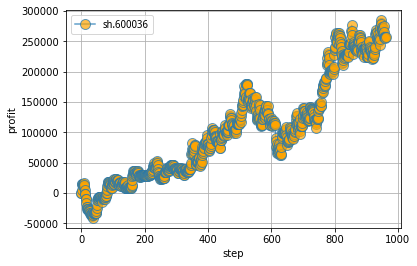

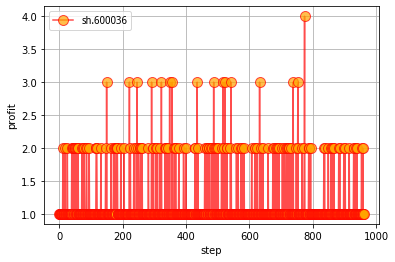

In [79]:
bins=np.array([0,1,2,3])
action_output=np.digitize(action_log,bins,right=False)
plot_results(daily_profits,action_output,stock_code)

In [42]:
stock_file = find_file('./stockdata/train', str('sh.600036'))
df=pd.read_csv(stock_file)
train,test,_=np.split(df, [int(.6*len(df)),int(len(df))-1])

In [43]:
test.reset_index(drop = True) 

,date,code,open,high,low,close,volume,amount,adjustflag,turn,tradestatus,pctChg,peTTM,pbMRQ,psTTM,pcfNcfTTM,isST
0,2015-12-17,sh.600036,17.00,17.12,16.95,17.10,50191055,8.560732e+08,3,0.243304,1,0.8255,7.358496,1.235835,2.188467,5.868592,0
1,2015-12-18,sh.600036,17.09,18.06,17.04,17.52,156986555,2.766476e+09,3,0.761001,1,2.4561,7.539231,1.266189,2.242219,6.012733,0
2,2015-12-21,sh.600036,17.43,18.45,17.35,18.23,152603076,2.749054e+09,3,0.739752,1,4.0525,7.844759,1.317501,2.333085,6.256400,0
3,2015-12-22,sh.600036,18.14,18.32,18.06,18.27,94006477,1.712027e+09,3,0.455702,1,0.2194,7.861972,1.320392,2.338205,6.270127,0
4,2015-12-23,sh.600036,18.28,18.71,18.17,18.19,108842854,2.005574e+09,3,0.527622,1,-0.4379,7.827546,1.314610,2.327966,6.242672,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
958,2019-11-22,sh.600036,36.70,36.85,36.08,36.23,32273896,1.175859e+09,3,0.156400,1,-0.5763,10.105343,1.624787,3.408570,7.934102,0
959,2019-11-25,sh.600036,36.40,36.72,36.32,36.58,26416258,9.660795e+08,3,0.128100,1,0.9661,10.202966,1.640483,3.441499,8.010750,0
960,2019-11-26,sh.600036,36.79,36.80,36.00,36.00,44859522,1.630208e+09,3,0.217500,1,-1.5856,10.041191,1.614472,3.386932,7.883734,0
961,2019-11-27,sh.600036,36.19,36.88,36.06,36.65,35069510,1.283181e+09,3,0.170000,1,1.8056,10.222490,1.643622,3.448085,8.026079,0


In [ ]:
test